In [1]:
# Import our module containing helper functions
import gravann

# Core imports
import numpy as np
import pickle as pk
import os
from collections import deque

# pytorch
from torch import nn
import torch

# plotting stuff
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

# Ensure that changes in imported module (gravann most importantly) are autoreloaded
%load_ext autoreload
%autoreload 2

# If possible enable CUDA
gravann.enableCUDA()
gravann.fixRandomSeeds()
device = os.environ["TORCH_DEVICE"]
print("Will use device ",device)

Available devices  10
__pyTorch VERSION: 2.4.1
__CUDNN VERSION: 90100
__Number CUDA Devices: 10
Active CUDA Device: GPU 0
Setting default tensor type to Float32
Will use device  cuda:0


/home/pietrofanti/miniforge3/envs/geodesynet/lib/python3.8/site-packages/torch/__init__.py:955: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /opt/conda/conda-bld/pytorch_1724789259345/work/torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)


In [2]:
# one of "eros", "bennu", "itokawa", "churyumov-gerasimenko", "planetesimal", "torus", "bennu_nu", "itokawa_nu", "planetesimal_nu"
name_of_gt = "bennu"

In [3]:
# We load the ground truth (a mascon model of some body)
with open("mascons/"+name_of_gt+".pk", "rb") as file:
    mascon_points, mascon_masses, mascon_name = pk.load(file)
    
mascon_points = torch.tensor(mascon_points)
mascon_masses = torch.tensor(mascon_masses)

# Print some information on the loaded ground truth 
# (non-dimensional units assumed. All mascon coordinates are thus in -1,1 and the mass is 1)
print("Name: ", mascon_name)
print("Number of mascons: ", len(mascon_points))
print("Total mass: ", sum(mascon_masses))

# Each mascon has a closest neighbour. The least close one is here computed (non dimensional units).
# Its a quantity that is of interest when checking mascon models coming from gravitationally stable aggregates.
print("Maximal minimal distance:",gravann.max_min_distance(mascon_points))

Name:  Bennu
Number of mascons:  37799
Total mass:  tensor(1.0000, dtype=torch.float64)
Maximal minimal distance: 0.13160134851932526


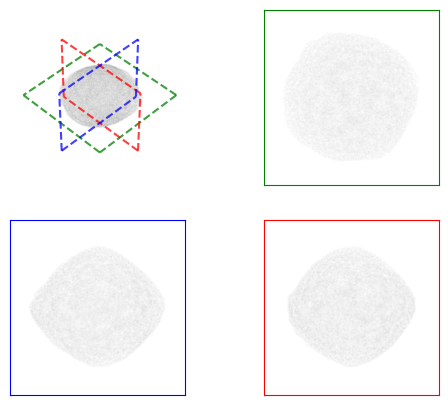

In [4]:
# Here we visualize the loaded ground truth
gravann.plot_mascon(mascon_points, mascon_masses,alpha=0.005)

In [ ]:
# models = [
#     {
#         "name": "Standard",
#         "checkpoint_name": "eros__classic",
#         "type": "siren",
#         "n_layers": 9,
#         "n_neurons": 100
#     },
#     {
#         "name": "Deeper",
#         "checkpoint_name": "eros__classic_27layers",
#         "type": "siren",
#         "n_layers": 27,
#         "n_neurons": 100
#     },
#     {
#         "name": "Wider",
#         "checkpoint_name": "eros__classic_175neurons",
#         "type": "siren",
#         "n_layers": 9,
#         "n_neurons": 175
#     },
#     {
#         "name": "Quadratic",
#         "checkpoint_name": "eros__quadratic",
#         "type": "siren_q",
#         "n_layers": 9,
#         "n_neurons": 100
#     },
#     {
#         "name": "Compound",
#         "checkpoint_name": "eros__classic_compund",
#         "type": "siren",
#         "n_layers": 15,
#         "n_neurons": 135
#     },
# ]

models = [
    # {
    #     "name": "Standard",
    #     "checkpoint_name": "bennu__classic",
    #     "type": "siren",
    #     "n_layers": 9,
    #     "n_neurons": 100
    # },
    # {
    #     "name": "Quadratic downscaled",
    #     "checkpoint_name": "bennu__quadratic_small",
    #     "type": "siren_q",
    #     "n_layers": 7,
    #     "n_neurons": 65
    # },
    {
        "name": "Width 100",
        "checkpoint_name": "bennu__classic_long",
        "type": "siren",
        "n_layers": 9,
        "n_neurons": 100
    },
    # {
    #     "name": "Quadratic",
    #     "checkpoint_name": "bennu__quadratic_long",
    #     "type": "siren_q",
    #     "n_layers": 9,
    #     "n_neurons": 100
    # },
    {
        "name": "9x135",
        "checkpoint_name": "bennu__less_wider_long",
        "type": "siren",
        "n_layers": 9,
        "n_neurons": 135
    },
    {
        "name": "9x175",
        "checkpoint_name": "bennu__wider_long",
        "type": "siren",
        "n_layers": 9,
        "n_neurons": 175
    },
    {
        "name": "7x65 qadratic",
        "checkpoint_name": "bennu__quadratic_small_long",
        "type": "siren_q",
        "n_layers": 7,
        "n_neurons": 65
    },
    {
        "name": "7x135",
        "checkpoint_name": "bennu__135_7",
        "type": "siren_q",
        "n_layers": 7,
        "n_neurons": 135
    },
]

encoding = gravann.direct_encoding()


In [36]:
for m in models:
    print(m["name"])
    m["model"] = gravann.init_network(
        encoding, n_neurons=m["n_neurons"], model_type=m["type"], activation=gravann.AbsLayer(), hidden_layers=m["n_layers"]
    )
    m["model"].load_state_dict(torch.load("models/"+m["checkpoint_name"]+".mdl"))
    m["c"] = gravann.compute_c_for_model(m["model"], encoding, mascon_points, mascon_masses, use_acc = True)
    m["model"].to(device="cpu")
    t = 0
    for p in m["model"].parameters():
        t += p.numel()
    m["n_parameters"] = t
    with open("logs/"+m["checkpoint_name"]+".pkl", 'rb') as f:
        log_dict = pk.load(f)
    for k,v in log_dict.items():
        m[k] = v

Width 100
Width 135
Width 175
Quadratic downscaled


In [37]:
models[0].keys()

dict_keys(['name', 'checkpoint_name', 'type', 'n_layers', 'n_neurons', 'model', 'c', 'n_parameters', 'loss', 'weighted_average_loss'])

In [38]:
def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

In [39]:
for m in models:
    print(m["name"])
    print(f"\thidden layers: {m['n_layers']}")
    print(f"\tneurons per layer: {m['n_neurons']}")
    print(f"\tquadratic layers: {m['type'] == 'siren_q'}")
    print(f"\tnumber of parameters: {m['n_parameters']}")
          

Width 100
	hidden layers: 9
	neurons per layer: 100
	quadratic layers: False
	number of parameters: 91401
Width 135
	hidden layers: 9
	neurons per layer: 135
	quadratic layers: False
	number of parameters: 165916
Width 175
	hidden layers: 9
	neurons per layer: 175
	quadratic layers: False
	number of parameters: 278076
Quadratic downscaled
	hidden layers: 7
	neurons per layer: 65
	quadratic layers: True
	number of parameters: 91068


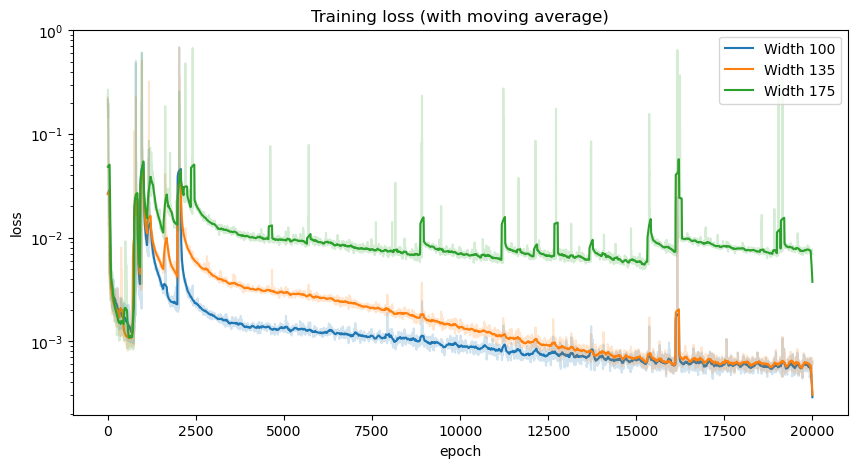

In [32]:
fig = plt.figure(figsize=(10, 5), dpi=100, facecolor='white')
ax0 = fig.add_subplot(111)
# ax1 = fig.add_subplot(122)
for i, m in enumerate(models):
    ax0.plot(m["loss"], alpha=0.2, color=f"C0{i}")
    ax0.plot(movingaverage(m["loss"], 100), color=f"C0{i}", label=m["name"])
    # ax1.plot(m["weighted_average_loss"], alpha=0.2, color=f"C0{i}")
    # ax1.plot(movingaverage(m["weighted_average_loss"], 100), color=f"C0{i}", label=m["name"])
ax0.legend()
ax0.set_title("Training loss (with moving average)")
ax0.set_xlabel("epoch")
ax0.set_ylabel("loss")
ax0.set_yscale("log")
# ax1.legend()
# ax1.set_title("Training weighted average loss (with moving average)")
# ax1.set_xlabel("epoch")
# ax1.set_ylabel("loss")
# ax1.set_yscale("log")

Sampling points...: 1842it [00:00, 5501.94it/s]
Sampling points...: 1855it [00:00, 5685.57it/s]
Sampling points...: 1766it [00:00, 5462.57it/s]


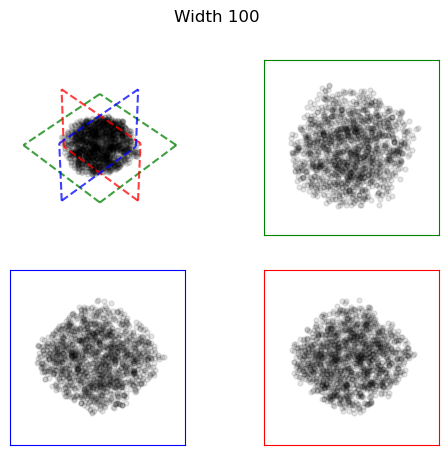

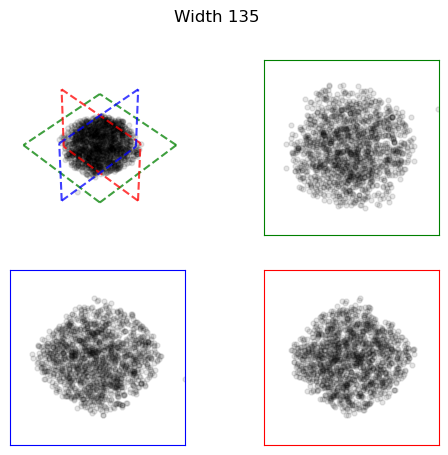

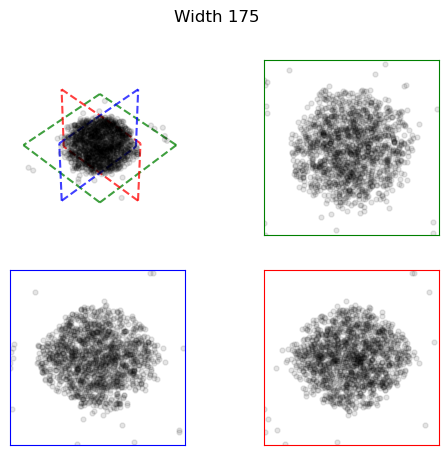

In [33]:
for m in models:
    m["model"].to(device=device)
    fig = gravann.plot_model_rejection(m["model"], encoding, views_2d=True, bw=True, N=1500, alpha=0.1, s=50, c=m["c"], crop_p=0.1, progressbar=True)
    m["model"].to(device="cpu")
    fig.suptitle(m["name"])

Sampling points...: 5437it [00:01, 5041.45it/s]                          
Sampling points...: 5155it [00:00, 5258.07it/s]
Sampling points...: 5090it [00:00, 6105.97it/s]
Computing validation...:  25%|██▍       | 18200/74244 [00:30<00:43, 1287.32it/s]

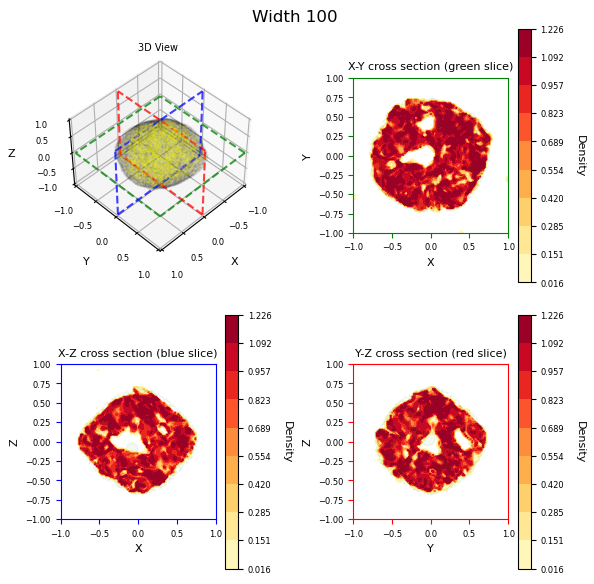

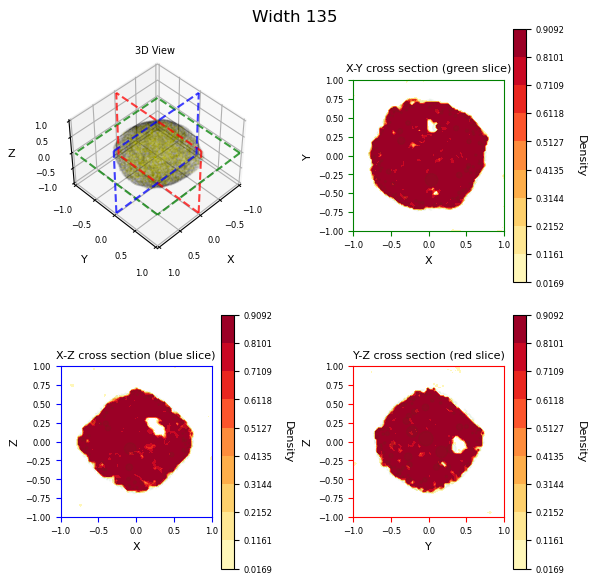

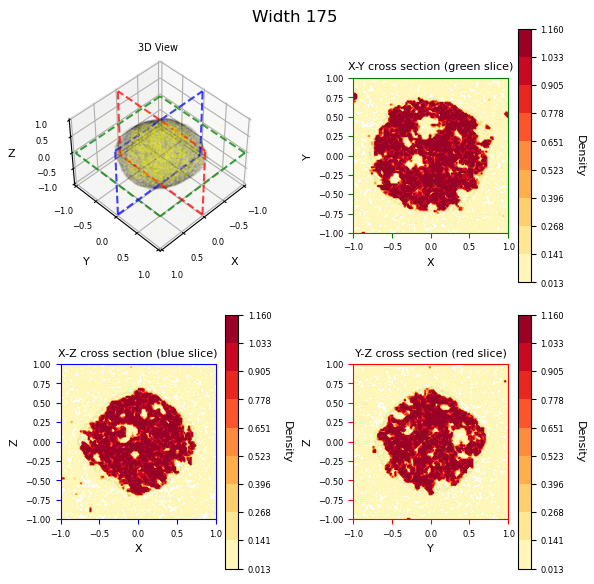

In [34]:
for m in models:
    m["model"].to(device=device)
    fig = gravann.plot_model_vs_mascon_contours(m["model"], encoding, mascon_points, mascon_masses,c=m["c"], progressbar = True, N=5000, heatmap=True)
    m["model"].to(device="cpu")
    plt.suptitle(m["name"])

In [26]:
for m in models:
    m["model"].to(device)
    results_geodesyNet = gravann.validation(m["model"], encoding, mascon_points, mascon_masses, 
        use_acc=True, 
        asteroid_pk_path="3dmeshes/"+name_of_gt+".pk", 
        N=10000, 
        N_integration=30000,  # This needs to be the same as the number used during training, else precision will be lost
        batch_size=100, 
        progressbar=True,
        sampling_altitudes=[0.05, 0.1, 0.25]
    )
    m["model"].to("cpu")
    m["results"] = results_geodesyNet

Computing validation...:  60%|█████▉    | 44300/74244 [00:33<00:22, 1338.34it/s]

Discarding 2610 of 14744 points in altitude sampler which did not meet requested altitude.


/home/pietrofanti/geodesyNets/gravann/_hulls.py:167: UserWarning: Using torch.cross without specifying the dim arg is deprecated.
Please either pass the dim explicitly or simply use torch.linalg.cross.
The default value of dim will change to agree with that of linalg.cross in a future release. (Triggered internally at /opt/conda/conda-bld/pytorch_1724789259345/work/aten/src/ATen/native/Cross.cpp:62.)
  h = torch.cross(ray_d.expand(V, 3), edge2)
Computing validation...:  73%|███████▎  | 54400/74244 [00:59<00:25, 778.74it/s] 

Discarding 7795 of 14744 points in altitude sampler which did not meet requested altitude.


Computing validation...:  87%|████████▋ | 64400/74244 [01:20<00:12, 780.71it/s]

Discarding 12502 of 14744 points in altitude sampler which did not meet requested altitude.


Computing validation...: 74400it [01:37, 766.61it/s]                           
Computing validation...:  60%|█████▉    | 44300/74244 [00:33<00:22, 1308.01it/s]

Discarding 2610 of 14744 points in altitude sampler which did not meet requested altitude.


Computing validation...:  73%|███████▎  | 54400/74244 [01:02<00:31, 622.83it/s] 

Discarding 7795 of 14744 points in altitude sampler which did not meet requested altitude.


Computing validation...:  87%|████████▋ | 64400/74244 [01:25<00:15, 633.59it/s]

Discarding 12502 of 14744 points in altitude sampler which did not meet requested altitude.


Computing validation...: 74400it [01:45, 703.35it/s]                           
Computing validation...:  24%|██▍       | 18100/74244 [00:13<00:43, 1287.32it/s]

KeyboardInterrupt: 